## CNN Neural Network (Manual) For Cancerous and Non-Cancerous Cell Classification

In [1]:
# minimal imports necessary for our manual implementation of CNN
import numpy as np
import pandas as pd
import cv2

## Preprocessing Data

In [ ]:
# Sources:
# Source - https://stackoverflow.com/a
# Posted by Usama Aleem
# Retrieved 2025-11-26, License - CC BY-SA 4.0
# Used for saving images

# https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c
# used to understand best image preprocessing practices
import os, sys
import matplotlib.pyplot as plt

'''
Converting images in the directory to .npy format for usability in CNN model.
We first load the image with cv2, grayscale it, then resize the image to a 
(128, 128) shape (for faster training). We then save these images to a directory called
color_cnn_data.

P.S. switched to non-grayscale because I realized that color images is important data for histopathology,
cancer detection and such. Let's also avoid such extreme compression
'''

def preprocess_images(chosen_dir: str):
    path = '../data/cancer_dataset/lung_colon_image_set/'
    path = path+chosen_dir
    dirs = os.listdir( path )
    dirs.sort()
    for item in dirs:
        image = cv2.imread(path+item)
        image = cv2.resize(image, (224, 224))
        # create the directory where the data will be stored
        dest_dir = os.path.join('smaller_cnn_data', chosen_dir)
        os.makedirs(dest_dir, exist_ok=True)
        out_path = os.path.join(dest_dir, item)
        cv2.imwrite(out_path, image)

# do not run these, files already created
# preprocess_images('colon_image_sets/colon_aca/')
# preprocess_images('colon_image_sets/colon_n/')
# preprocess_images('lung_image_sets/lung_aca/')
# preprocess_images('lung_image_sets/lung_n/')
# preprocess_images('lung_image_sets/lung_scc/')



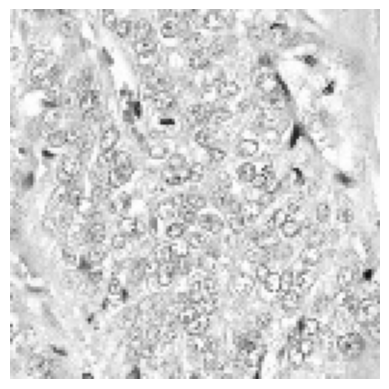

In [ ]:
# Ensure images are properly printed out
img = cv2.imread('smaller_cnn_data/colon_image_sets/colon_aca/colonca1.jpeg')
plt.imshow(img)
plt.axis('off') 
plt.show()

In [ ]:
# split the testing, validation, and training data
# read the data then split based on 
import math
import random

'''
Split the data into separate folders. 70% used for training, 15% used for validation, and
the last 15% used for testing. Images from the smaller_cnn_data are randomly shuffled, and 
images are then copied to the model_train_val_test directory based on pre-defined ratios.
'''
def split_data(subdir: str, train_ratio=0.7, val_ratio=0.15):
    path = os.path.join('smaller_cnn_data/', subdir)
    dirs = os.listdir( path )
    i = 0
    random.shuffle(dirs)
    img_count = len(dirs)
    train_count = math.floor(img_count * train_ratio)
    val_count = train_count + math.floor(img_count * val_ratio)
    for item in dirs:
        image = cv2.imread(os.path.join(path, item))
        if image is None:
            print("Couldn't read:", item)
            continue
        dest_subdir = os.path.basename(os.path.normpath(path))
        if i < train_count:
            dest_dir = os.path.join('model_train_val_test/train/', dest_subdir)
        elif i < val_count:
            dest_dir = os.path.join('model_train_val_test/val/', dest_subdir)
        else:
            dest_dir = os.path.join('model_train_val_test/test/', dest_subdir)

        os.makedirs(dest_dir, exist_ok=True)
        out_path = os.path.join(dest_dir, item)
        cv2.imwrite(out_path, image)
        i = i + 1

# split_data('colon_image_sets/colon_aca/')
# split_data('colon_image_sets/colon_n/')
# split_data('lung_image_sets/lung_aca/')
# split_data('lung_image_sets/lung_n/')
# split_data('lung_image_sets/lung_scc/')

## Construct the CNN Training Model

Create training for our model: One for Binary classification, and one for Multiclass classification

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras.losses import binary_crossentropy
from keras.losses import categorical_crossentropy

In [6]:
# Creating the categorical classification model

In [ ]:
# to build a CNN with multiple Convolutional Layers
# We use 3 x 3 kernels for every convolutional layers, 
# and double filters every layer. Padding is added to 
# capture details of edges. Pooling layers are
# are always a size of 2 with a stride of 2, to generalize and
# reduce dimensionality. Finally, we flatten for the Dense layer,
# and output results of the Dense layer to the output layer

train_dataset = keras.utils.image_dataset_from_directory(
    'model_train_val_test/train/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
).prefetch(tf.data.AUTOTUNE)

val_dataset = keras.utils.image_dataset_from_directory(
    'model_train_val_test/val/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
).prefetch(tf.data.AUTOTUNE)

test_dataset = keras.utils.image_dataset_from_directory(
    'model_train_val_test/test/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
).prefetch(tf.data.AUTOTUNE)

for images, labels in train_dataset.take(1):
    print('Image data shape', images.shape)
    print('Classification Labels shape', labels.shape)

# Source of reference: https://www.tensorflow.org/tutorials/images/cnn (Tensorflow CNN tutorial)
model = Sequential([
    keras.Input(shape=(128, 128, 1), batch_size=32),
    keras.layers.Rescaling(1./255),
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.Conv2D(16, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),    # same shape as original picture
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax'),
], name="model")



Found 17500 files belonging to 5 classes.
Found 3750 files belonging to 5 classes.
Found 3750 files belonging to 5 classes.
Image data shape (32, 128, 128, 1)
Classification Labels shape (32, 5)


In [62]:
# compile the model
model.compile(optimizer=SGD(),
              loss=categorical_crossentropy,
              metrics=['accuracy', 'precision', 'recall', 'AUC'])

In [63]:
# get the summary of the model. Are the input an output layer sizes matching?
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_18 (Rescaling)        │ (32, 128, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_18 (RandomFlip)     │ (32, 128, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_18              │ (32, 128, 128, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_18 (RandomZoom)     │ (32, 128, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (32, 126, 126, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (32, 63, 63, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (32, 61, 61, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (32, 30, 30, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (32, 28, 28, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (32, 128)              │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,637,637 (6.25 MB)

 Trainable params: 1,637,637 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# now fit the model
history = model.fit(train_dataset, batch_size=32, epochs=100, validation_data=val_dataset)

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - AUC: 0.6094 - accuracy: 0.2705 - loss: 1.5561 - precision: 0.5339 - recall: 0.0072 - val_AUC: 0.5406 - val_accuracy: 0.2000 - val_loss: 1.6992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 0.7510 - accuracy: 0.3858 - loss: 1.3440 - precision: 0.5706 - recall: 0.1053 - val_AUC: 0.8738 - val_accuracy: 0.5317 - val_loss: 1.0173 - val_precision: 0.8037 - val_recall: 0.2096
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - AUC: 0.8192 - accuracy: 0.4657 - loss: 1.1651 - precision: 0.5970 - recall: 0.2006 - val_AUC: 0.8642 - val_accuracy: 0.5227 - val_loss: 1.0229 - val_precision: 0.5884 - val_recall: 0.2867
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - AUC: 0.8478 - accuracy: 0.5019 - loss: 1.0643 - precision: 0.6204 - recall: 0.2598 - val_AUC: 0.8594 - val_accuracy: 0.5125 - val_loss: 1.0355 - val_precision: 0.5884 - val_recall: 0.2859
Epoch 5/100


In [65]:
loss, accuracy, precision, recall, auc = model.evaluate(test_dataset)
f1 = (2 * precision * recall) / (precision + recall)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {auc:.4f}')

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.9959 - accuracy: 0.9443 - loss: 0.1433 - precision: 0.9443 - recall: 0.9443
Test Loss: 0.1433
Test Accuracy: 0.9443
Test Precision: 0.9443
Test Recall: 0.9959


In [66]:
# save the weights
model.save_weights('weights/categorical_cnn.weights.h5')

## Results and Overfitting Plots

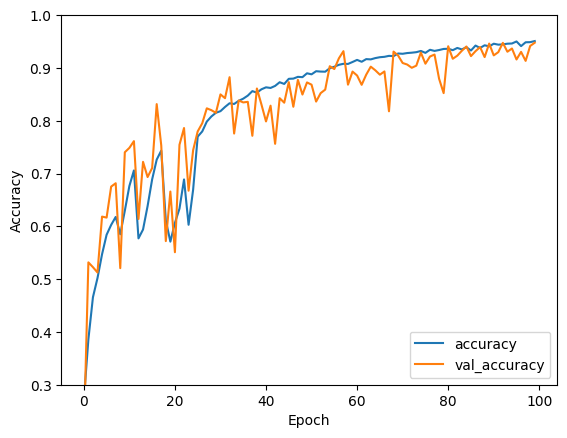

In [67]:
# print the training accuracy and val accuracy over each other
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

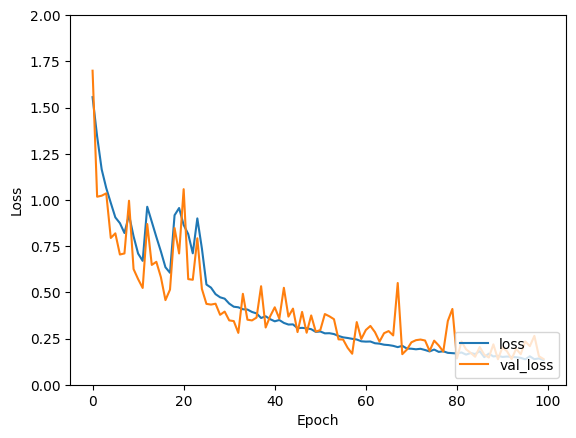

In [68]:
# print the training loss and val loss over each other
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

In [ ]:
# check for overfitting
# loop through all the weights from the model
# use to predict test data
# calc loss from each set of preds
# plot on top of training loss vs. test loss


In [ ]:
# add more metrics and plots here

In [ ]:
# split the testing, validation, and training data, this time for binary purposes
import math
import random

def split_data_binary(subdir: str, dest_subdir: str, train_ratio=0.7, val_ratio=0.15):
    path = os.path.join('color_cnn_data/', subdir)
    dirs = os.listdir( path )
    dirs.sort()
    i = 0
    random.shuffle(dirs)
    img_count = len(dirs)
    train_count = math.floor(img_count * train_ratio)
    val_count = train_count + math.floor(img_count * val_ratio)
    for item in dirs:
        image = cv2.imread(os.path.join(path, item))
        if image is None:
            print("Couldn't read:", item)
            continue
        if i < train_count:
            dest_dir = os.path.join('color_bin_train_val_test/train/', dest_subdir)
        elif i < val_count:
            dest_dir = os.path.join('color_bin_train_val_test/val/', dest_subdir)
        else:
            dest_dir = os.path.join('color_bin_train_val_test/test/', dest_subdir)

        os.makedirs(dest_dir, exist_ok=True)
        out_path = os.path.join(dest_dir, item)
        cv2.imwrite(out_path, image)
        i = i + 1

# split_data_binary('colon_image_sets/colon_aca/', 'cancerous')
# split_data_binary('colon_image_sets/colon_n/', 'non-cancerous')
# split_data_binary('lung_image_sets/lung_aca/', 'cancerous')
# split_data_binary('lung_image_sets/lung_n/', 'non-cancerous')
# split_data_binary('lung_image_sets/lung_scc/', 'cancerous')

In [ ]:
# create a binary classification model, can we detect cancer in general?

# to build a CNN with one Convolutional Layer
# (with a single 3 by 3 kernel with stride 1 and no activation
# and a single hidden layer with ReLU activation
# and using the sigmoid activation for the output

# use standard kernel size (3, 3) to capture detail of images
train_dataset = keras.utils.image_dataset_from_directory(
    'binary_train_val_test/train/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='binary',
).prefetch(tf.data.AUTOTUNE)

val_dataset = keras.utils.image_dataset_from_directory(
    'binary_train_val_test/val/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='binary',
).prefetch(tf.data.AUTOTUNE)

test_dataset = keras.utils.image_dataset_from_directory(
    'binary_train_val_test/test/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='binary',
).prefetch(tf.data.AUTOTUNE)

for images, labels in train_dataset.take(1):
    print('Image data shape', images.shape)
    print('Classification Labels shape', labels.shape)

# Source of reference: https://www.tensorflow.org/tutorials/images/cnn (Tensorflow CNN tutorial)
bin_model = Sequential([
    keras.Input(shape=(128, 128, 1), batch_size=32),
    keras.layers.Rescaling(1./255),
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.Conv2D(16, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),    # same shape as original picture
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax'),
], name="model")



Found 17500 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
(32, 128, 128, 1)
(32, 1)


In [ ]:
# compile the model
bin_model.compile(optimizer=SGD(),
              loss=binary_crossentropy,
              metrics=['accuracy', 'precision', 'recall', 'AUC'])

In [ ]:
# now fit the model
bin_history = bin_model.fit(train_dataset, batch_size=32, epochs=100, validation_data=val_dataset)

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - AUC: 0.4837 - accuracy: 0.5992 - loss: 0.6780 - precision: 0.4453 - recall: 0.0081 - val_AUC: 0.6408 - val_accuracy: 0.6000 - val_loss: 0.6715 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - AUC: 0.5990 - accuracy: 0.6025 - loss: 0.6623 - precision: 0.5570 - recall: 0.0300 - val_AUC: 0.7257 - val_accuracy: 0.6112 - val_loss: 0.6503 - val_precision: 0.5132 - val_recall: 0.5447
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 0.6664 - accuracy: 0.6238 - loss: 0.6271 - precision: 0.5527 - recall: 0.3117 - val_AUC: 0.7318 - val_accuracy: 0.6483 - val_loss: 0.5858 - val_precision: 0.5729 - val_recall: 0.4740
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 0.6836 - accuracy: 0.6224 - loss: 0.6053 - precision: 0.5426 - recall: 0.3570 - val_AUC: 0.7410 - val_accuracy: 0.6629 - val_loss: 0.5605 - val_precision: 0.6005 - val_recall: 0.4700
Epoch 5/50
547/5

In [ ]:
bin_loss, bin_accuracy, bin_precision, bin_recall, bin_auc = bin_model.evaluate(test_dataset)
bin_f1 = 2 * bin_precision * bin_recall
print(f'Test Loss: {bin_loss:.4f}')
print(f'Test Accuracy: {bin_accuracy:.4f}')
print(f'Test Precision: {bin_precision:.4f}')
print(f'Test Recall: {bin_recall:.4f}')



118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.9972 - accuracy: 0.9747 - loss: 0.0775 - precision: 0.9495 - recall: 0.9893
Test Loss: 0.0775
Test Accuracy: 0.9747
Test Precision: 0.9495
Test Recall: 0.9893


In [ ]:
# save the weights
model.save_weights('weights/binary_cnn.weights.h5')

In [ ]:
# check for overfitting
# loop through all the weights from the model
# use to predict test data
# calc loss from each set of preds
# plot on top of training loss vs. test loss

# print the training accuracy and val accuracy over each other
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

In [ ]:
# print the training loss and val loss over each other
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

## CNN categorical + Bayesian Network
Can we achieve a higher accuracy with the addition of a bayesian network?